# Fine-Tuning GPT-2 on Encrypted Data with LoRA and Concrete-ML

In this notebook, we peform fine-tuning of a GPT-2 model using LoRA and Concrete-ML. This allows us to fine-tune a model in a privacy-preserving manner.

LoRA weight can be used 

In [1]:
# Import necessary libraries
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from peft import LoraConfig, TaskType, get_peft_model
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TextDataset,
    Trainer,
    TrainingArguments,
)
from utils_lora import generate_text, get_remote_names, print_weights_and_size, replace_conv1d

from concrete.ml.torch.hybrid_model import HybridFHEModel
from concrete.ml.torch.lora import LoraTraining

# Set random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [2]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [3]:
# Example usage of the pre-trained model
prompt = "What is FHE?"
generated_text = generate_text(prompt, model, tokenizer)
print(generated_text)

What is FHE?

FHE is a new form of electromagnetic radiation that is produced by the electromagnetic fields generated by microwaves. It is an electromagnetic wave that travels


In [4]:
# Configure LoRA
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    fan_in_fan_out=True,
)

# Apply LoRA to the model
peft_model = get_peft_model(model, peft_config)

In [5]:
# Replace Conv1D layers with CustomConv1D for FHE compatibility
# Skip the first Conv1D layer (module_index_to_skip=0)
replace_conv1d(peft_model, module_index_to_skip=0)

-1

In [6]:
# Set up LoRA training
GRADIENT_ACCUMULATION_STEPS = 2
lora_training = LoraTraining(peft_model, GRADIENT_ACCUMULATION_STEPS)

In [7]:
# Prepare dataset for fine-tuning
BLOCK_SIZE = 128

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="data_finetune/what_is_fhe.txt",
    block_size=BLOCK_SIZE,
    cache_dir="cache_dataset",
)

In [8]:
# Set up data collator for language modeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Define training arguments
EPOCHS = 100
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=5e-4,
    logging_strategy="epoch",
    optim="adamw_torch",
    seed=SEED,
    data_seed=SEED,
    weight_decay=0.0,
    warmup_steps=0,
    max_grad_norm=1.0,
)

In [9]:
# Initialize Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

# Prepare for training
train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lora_training.update_training_parameters(trainer.optimizer, trainer.lr_scheduler, training_args)

In [10]:
# Get the names of the remote modules (layers to be converted to FHE)
remote_names = get_remote_names(lora_training, include_embedding_layers=False)

In [11]:
# Create the HybridFHEModel with the specified remote modules
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [12]:
# Prepare input data for calibration
input_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)
label_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)

inputset = (input_tensor, label_tensor)

In [13]:
# Calibrate and compile the model
hybrid_model.model.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=16)
hybrid_model.model.toggle_calibrate(enable=False)

In [14]:
def train_custom_model(
    hybrid_model, train_dataloader, training_args, fhe="disable"
):  # pylint: disable=too-many-locals
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    hybrid_model.model.inference_model.train()

    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []  # List to store the loss for each epoch

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        steps_in_epoch = len(train_dataloader)
        for step, batch in enumerate(train_dataloader):
            total_batched_samples += 1

            batch = {k: v.to(device) for k, v in batch.items()}

            # Gradient accumulation
            is_within_accumulation_steps = (
                steps_in_epoch <= training_args.gradient_accumulation_steps
            )
            is_last_step_in_epoch = (step + 1) == steps_in_epoch

            is_last_batch_step = is_within_accumulation_steps and is_last_step_in_epoch

            mod_total_batched_samples = (
                total_batched_samples % training_args.gradient_accumulation_steps
            )
            accumulate_gradients = mod_total_batched_samples == 0

            run_optimizer = is_last_batch_step or accumulate_gradients

            hybrid_model.model.toggle_run_optimizer(enable=run_optimizer)

            loss, grad_norm = hybrid_model((batch["input_ids"], batch["labels"]), fhe=fhe)

            total_loss += loss.item()

            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = hybrid_model.model.lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1] if grad_norms else None

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        hybrid_model.model.inference_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   1%|          | 1/100 [04:13<6:58:00, 253.34s/it]

Epoch 1/100, Loss: 1.5293, grad norm: 0.43492022156715393, lr: 0.000495


Training Progress:   2%|▏         | 2/100 [06:27<4:59:25, 183.33s/it]

Epoch 2/100, Loss: 1.5049, grad norm: 0.352533221244812, lr: 0.00049


Training Progress:   3%|▎         | 3/100 [08:25<4:07:52, 153.32s/it]

Epoch 3/100, Loss: 1.5095, grad norm: 0.3519188463687897, lr: 0.00048499999999999997


Training Progress:   4%|▍         | 4/100 [10:24<3:43:46, 139.86s/it]

Epoch 4/100, Loss: 1.4951, grad norm: 0.4220981299877167, lr: 0.00048


Training Progress:   5%|▌         | 5/100 [12:21<3:28:23, 131.61s/it]

Epoch 5/100, Loss: 1.4520, grad norm: 0.3912947177886963, lr: 0.000475


Training Progress:   6%|▌         | 6/100 [14:21<3:19:49, 127.55s/it]

Epoch 6/100, Loss: 1.4538, grad norm: 0.44015318155288696, lr: 0.00047


Training Progress:   7%|▋         | 7/100 [16:23<3:15:05, 125.86s/it]

Epoch 7/100, Loss: 1.4215, grad norm: 0.4665907919406891, lr: 0.000465


Training Progress:   8%|▊         | 8/100 [18:20<3:08:47, 123.12s/it]

Epoch 8/100, Loss: 1.3922, grad norm: 0.3972119688987732, lr: 0.00046


Training Progress:   9%|▉         | 9/100 [20:23<3:06:26, 122.92s/it]

Epoch 9/100, Loss: 1.3783, grad norm: 0.5103384852409363, lr: 0.000455


Training Progress:  10%|█         | 10/100 [22:20<3:01:53, 121.26s/it]

Epoch 10/100, Loss: 1.3901, grad norm: 0.4718356728553772, lr: 0.00045000000000000004


Training Progress:  11%|█         | 11/100 [24:19<2:58:45, 120.51s/it]

Epoch 11/100, Loss: 1.3585, grad norm: 0.47023946046829224, lr: 0.00044500000000000003


Training Progress:  12%|█▏        | 12/100 [26:17<2:55:29, 119.66s/it]

Epoch 12/100, Loss: 1.3388, grad norm: 0.4369097352027893, lr: 0.00044


Training Progress:  13%|█▎        | 13/100 [28:14<2:52:37, 119.05s/it]

Epoch 13/100, Loss: 1.3128, grad norm: 0.46198874711990356, lr: 0.000435


Training Progress:  14%|█▍        | 14/100 [30:12<2:49:52, 118.52s/it]

Epoch 14/100, Loss: 1.3002, grad norm: 0.4585149884223938, lr: 0.00043


Training Progress:  15%|█▌        | 15/100 [32:09<2:47:23, 118.16s/it]

Epoch 15/100, Loss: 1.2632, grad norm: 0.4551805555820465, lr: 0.000425


Training Progress:  16%|█▌        | 16/100 [34:40<2:59:22, 128.12s/it]

Epoch 16/100, Loss: 1.2839, grad norm: 0.4982885718345642, lr: 0.00042


Training Progress:  17%|█▋        | 17/100 [37:13<3:07:24, 135.47s/it]

Epoch 17/100, Loss: 1.2378, grad norm: 0.5008432865142822, lr: 0.000415


Training Progress:  18%|█▊        | 18/100 [39:41<3:10:11, 139.16s/it]

Epoch 18/100, Loss: 1.2308, grad norm: 0.8382067680358887, lr: 0.00041


Training Progress:  19%|█▉        | 19/100 [41:58<3:06:56, 138.48s/it]

Epoch 19/100, Loss: 1.2091, grad norm: 0.5587419867515564, lr: 0.00040500000000000003


Training Progress:  20%|██        | 20/100 [44:00<2:58:02, 133.53s/it]

Epoch 20/100, Loss: 1.1761, grad norm: 0.6175819039344788, lr: 0.0004


Training Progress:  21%|██        | 21/100 [46:02<2:51:33, 130.29s/it]

Epoch 21/100, Loss: 1.1782, grad norm: 0.5811882615089417, lr: 0.000395


Training Progress:  22%|██▏       | 22/100 [48:03<2:45:48, 127.54s/it]

Epoch 22/100, Loss: 1.1394, grad norm: 0.6143437623977661, lr: 0.00039000000000000005


Training Progress:  23%|██▎       | 23/100 [50:04<2:41:06, 125.53s/it]

Epoch 23/100, Loss: 1.1266, grad norm: 0.5669662952423096, lr: 0.00038500000000000003


Training Progress:  24%|██▍       | 24/100 [52:14<2:40:24, 126.64s/it]

Epoch 24/100, Loss: 1.1210, grad norm: 0.5340665578842163, lr: 0.00038


Training Progress:  25%|██▌       | 25/100 [54:18<2:37:21, 125.88s/it]

Epoch 25/100, Loss: 1.1296, grad norm: 0.7689154744148254, lr: 0.000375


Training Progress:  26%|██▌       | 26/100 [56:18<2:33:07, 124.15s/it]

Epoch 26/100, Loss: 1.0778, grad norm: 0.6537386775016785, lr: 0.00037


Training Progress:  27%|██▋       | 27/100 [58:15<2:28:32, 122.09s/it]

Epoch 27/100, Loss: 1.0729, grad norm: 0.5519561171531677, lr: 0.000365


Training Progress:  28%|██▊       | 28/100 [1:00:12<2:24:50, 120.70s/it]

Epoch 28/100, Loss: 1.0707, grad norm: 0.631074845790863, lr: 0.00035999999999999997


Training Progress:  29%|██▉       | 29/100 [1:02:10<2:21:35, 119.65s/it]

Epoch 29/100, Loss: 1.0379, grad norm: 0.605238139629364, lr: 0.000355


Training Progress:  30%|███       | 30/100 [1:04:10<2:19:44, 119.78s/it]

Epoch 30/100, Loss: 1.0507, grad norm: 0.7176390886306763, lr: 0.00035


Training Progress:  31%|███       | 31/100 [1:06:13<2:18:47, 120.68s/it]

Epoch 31/100, Loss: 0.9954, grad norm: 0.6177290678024292, lr: 0.000345


Training Progress:  32%|███▏      | 32/100 [1:08:12<2:16:28, 120.42s/it]

Epoch 32/100, Loss: 1.0046, grad norm: 0.5920649766921997, lr: 0.00034


Training Progress:  33%|███▎      | 33/100 [1:10:09<2:13:11, 119.27s/it]

Epoch 33/100, Loss: 1.0009, grad norm: 0.6858815550804138, lr: 0.000335


Training Progress:  34%|███▍      | 34/100 [1:12:06<2:10:23, 118.54s/it]

Epoch 34/100, Loss: 0.9593, grad norm: 0.6384243965148926, lr: 0.00033


Training Progress:  35%|███▌      | 35/100 [1:14:02<2:07:41, 117.86s/it]

Epoch 35/100, Loss: 0.9673, grad norm: 0.6874094009399414, lr: 0.00032500000000000004


Training Progress:  36%|███▌      | 36/100 [1:15:59<2:05:29, 117.64s/it]

Epoch 36/100, Loss: 0.9503, grad norm: 0.6873466968536377, lr: 0.00032


Training Progress:  37%|███▋      | 37/100 [1:17:56<2:03:16, 117.41s/it]

Epoch 37/100, Loss: 0.9242, grad norm: 0.872063159942627, lr: 0.000315


Training Progress:  38%|███▊      | 38/100 [1:19:54<2:01:22, 117.46s/it]

Epoch 38/100, Loss: 0.9108, grad norm: 0.7574602961540222, lr: 0.00031


Training Progress:  39%|███▉      | 39/100 [1:21:51<1:59:26, 117.48s/it]

Epoch 39/100, Loss: 0.8989, grad norm: 0.7510356307029724, lr: 0.000305


Training Progress:  40%|████      | 40/100 [1:23:48<1:57:09, 117.16s/it]

Epoch 40/100, Loss: 0.8946, grad norm: 0.9030724167823792, lr: 0.0003


Training Progress:  41%|████      | 41/100 [1:25:49<1:56:24, 118.38s/it]

Epoch 41/100, Loss: 0.8843, grad norm: 0.7663012742996216, lr: 0.000295


Training Progress:  42%|████▏     | 42/100 [1:27:45<1:53:49, 117.74s/it]

Epoch 42/100, Loss: 0.8388, grad norm: 0.8004553914070129, lr: 0.00029


Training Progress:  43%|████▎     | 43/100 [1:29:44<1:52:15, 118.16s/it]

Epoch 43/100, Loss: 0.8584, grad norm: 0.9167132377624512, lr: 0.000285


Training Progress:  44%|████▍     | 44/100 [1:31:40<1:49:36, 117.44s/it]

Epoch 44/100, Loss: 0.8553, grad norm: 0.7745354175567627, lr: 0.00028000000000000003


Training Progress:  45%|████▌     | 45/100 [1:33:38<1:47:47, 117.59s/it]

Epoch 45/100, Loss: 0.8354, grad norm: 0.8482704758644104, lr: 0.000275


Training Progress:  46%|████▌     | 46/100 [1:35:34<1:45:20, 117.05s/it]

Epoch 46/100, Loss: 0.8256, grad norm: 0.8537431955337524, lr: 0.00027


Training Progress:  47%|████▋     | 47/100 [1:37:31<1:43:20, 116.99s/it]

Epoch 47/100, Loss: 0.8185, grad norm: 0.8929233551025391, lr: 0.00026500000000000004


Training Progress:  48%|████▊     | 48/100 [1:39:27<1:41:15, 116.84s/it]

Epoch 48/100, Loss: 0.8162, grad norm: 0.8364350199699402, lr: 0.00026000000000000003


Training Progress:  49%|████▉     | 49/100 [1:41:24<1:39:19, 116.86s/it]

Epoch 49/100, Loss: 0.8138, grad norm: 1.0447884798049927, lr: 0.000255


Training Progress:  50%|█████     | 50/100 [1:43:21<1:37:23, 116.88s/it]

Epoch 50/100, Loss: 0.7967, grad norm: 0.8563845753669739, lr: 0.00025


Training Progress:  51%|█████     | 51/100 [1:45:18<1:35:29, 116.92s/it]

Epoch 51/100, Loss: 0.7846, grad norm: 1.0062382221221924, lr: 0.000245


Training Progress:  52%|█████▏    | 52/100 [1:47:15<1:33:29, 116.87s/it]

Epoch 52/100, Loss: 0.7439, grad norm: 0.8428460359573364, lr: 0.00024


Training Progress:  53%|█████▎    | 53/100 [1:49:13<1:31:53, 117.31s/it]

Epoch 53/100, Loss: 0.7578, grad norm: 0.8999559283256531, lr: 0.000235


Training Progress:  54%|█████▍    | 54/100 [1:51:12<1:30:18, 117.78s/it]

Epoch 54/100, Loss: 0.7499, grad norm: 0.96401447057724, lr: 0.00023


Training Progress:  55%|█████▌    | 55/100 [1:53:09<1:28:17, 117.72s/it]

Epoch 55/100, Loss: 0.7307, grad norm: 1.0235702991485596, lr: 0.00022500000000000002


Training Progress:  56%|█████▌    | 56/100 [1:55:07<1:26:22, 117.78s/it]

Epoch 56/100, Loss: 0.7436, grad norm: 1.019648790359497, lr: 0.00022


Training Progress:  57%|█████▋    | 57/100 [1:57:06<1:24:31, 117.94s/it]

Epoch 57/100, Loss: 0.7072, grad norm: 1.0293934345245361, lr: 0.000215


Training Progress:  58%|█████▊    | 58/100 [1:59:05<1:22:55, 118.45s/it]

Epoch 58/100, Loss: 0.7108, grad norm: 0.9379361867904663, lr: 0.00021


Training Progress:  59%|█████▉    | 59/100 [2:01:03<1:20:48, 118.25s/it]

Epoch 59/100, Loss: 0.7145, grad norm: 0.8663557767868042, lr: 0.000205


Training Progress:  60%|██████    | 60/100 [2:03:05<1:19:28, 119.21s/it]

Epoch 60/100, Loss: 0.6868, grad norm: 0.974902868270874, lr: 0.0002


Training Progress:  61%|██████    | 61/100 [2:05:06<1:17:54, 119.86s/it]

Epoch 61/100, Loss: 0.7064, grad norm: 1.1623306274414062, lr: 0.00019500000000000002


Training Progress:  62%|██████▏   | 62/100 [2:07:21<1:18:45, 124.35s/it]

Epoch 62/100, Loss: 0.6720, grad norm: 1.0193554162979126, lr: 0.00019


Training Progress:  63%|██████▎   | 63/100 [2:09:42<1:19:43, 129.28s/it]

Epoch 63/100, Loss: 0.6688, grad norm: 1.0225757360458374, lr: 0.000185


Training Progress:  64%|██████▍   | 64/100 [2:12:10<1:21:01, 135.04s/it]

Epoch 64/100, Loss: 0.6519, grad norm: 1.1080639362335205, lr: 0.00017999999999999998


Training Progress:  65%|██████▌   | 65/100 [2:14:37<1:20:48, 138.54s/it]

Epoch 65/100, Loss: 0.6656, grad norm: 1.0842102766036987, lr: 0.000175


Training Progress:  66%|██████▌   | 66/100 [2:17:03<1:19:48, 140.84s/it]

Epoch 66/100, Loss: 0.6632, grad norm: 1.0385353565216064, lr: 0.00017


Training Progress:  67%|██████▋   | 67/100 [2:19:04<1:14:14, 134.99s/it]

Epoch 67/100, Loss: 0.6333, grad norm: 1.0786832571029663, lr: 0.000165


Training Progress:  68%|██████▊   | 68/100 [2:21:02<1:09:16, 129.90s/it]

Epoch 68/100, Loss: 0.6248, grad norm: 1.1498541831970215, lr: 0.00016


Training Progress:  69%|██████▉   | 69/100 [2:23:04<1:05:52, 127.48s/it]

Epoch 69/100, Loss: 0.6158, grad norm: 1.0729987621307373, lr: 0.000155


Training Progress:  70%|███████   | 70/100 [2:25:02<1:02:13, 124.46s/it]

Epoch 70/100, Loss: 0.6147, grad norm: 1.0749378204345703, lr: 0.00015


Training Progress:  71%|███████   | 71/100 [2:27:17<1:01:42, 127.67s/it]

Epoch 71/100, Loss: 0.6362, grad norm: 1.116703987121582, lr: 0.000145


Training Progress:  72%|███████▏  | 72/100 [2:29:43<1:02:08, 133.15s/it]

Epoch 72/100, Loss: 0.6331, grad norm: 1.1760586500167847, lr: 0.00014000000000000001


Training Progress:  73%|███████▎  | 73/100 [2:32:21<1:03:18, 140.67s/it]

Epoch 73/100, Loss: 0.6004, grad norm: 1.054480791091919, lr: 0.000135


Training Progress:  74%|███████▍  | 74/100 [2:34:47<1:01:43, 142.46s/it]

Epoch 74/100, Loss: 0.6501, grad norm: 1.2597455978393555, lr: 0.00013000000000000002


Training Progress:  75%|███████▌  | 75/100 [2:37:24<1:01:06, 146.67s/it]

Epoch 75/100, Loss: 0.5887, grad norm: 0.980426013469696, lr: 0.000125


Training Progress:  76%|███████▌  | 76/100 [2:39:47<58:17, 145.72s/it]  

Epoch 76/100, Loss: 0.6187, grad norm: 1.1994532346725464, lr: 0.00012


Training Progress:  77%|███████▋  | 77/100 [2:42:24<57:04, 148.88s/it]

Epoch 77/100, Loss: 0.5909, grad norm: 1.2743654251098633, lr: 0.000115


Training Progress:  78%|███████▊  | 78/100 [2:44:54<54:46, 149.40s/it]

Epoch 78/100, Loss: 0.6026, grad norm: 1.0403355360031128, lr: 0.00011


Training Progress:  79%|███████▉  | 79/100 [2:47:16<51:30, 147.16s/it]

Epoch 79/100, Loss: 0.5930, grad norm: 1.3838145732879639, lr: 0.000105


Training Progress:  80%|████████  | 80/100 [2:49:49<49:34, 148.75s/it]

Epoch 80/100, Loss: 0.6335, grad norm: 1.3230136632919312, lr: 0.0001


Training Progress:  81%|████████  | 81/100 [2:52:09<46:18, 146.22s/it]

Epoch 81/100, Loss: 0.5854, grad norm: 1.0707461833953857, lr: 9.5e-05


Training Progress:  82%|████████▏ | 82/100 [2:54:36<43:56, 146.45s/it]

Epoch 82/100, Loss: 0.5686, grad norm: 1.0715218782424927, lr: 8.999999999999999e-05


Training Progress:  83%|████████▎ | 83/100 [2:56:59<41:13, 145.50s/it]

Epoch 83/100, Loss: 0.5570, grad norm: 1.1147339344024658, lr: 8.5e-05


Training Progress:  84%|████████▍ | 84/100 [2:59:45<40:23, 151.50s/it]

Epoch 84/100, Loss: 0.5660, grad norm: 1.142927646636963, lr: 8e-05


Training Progress:  85%|████████▌ | 85/100 [3:02:37<39:27, 157.81s/it]

Epoch 85/100, Loss: 0.5466, grad norm: 1.1076529026031494, lr: 7.5e-05


Training Progress:  86%|████████▌ | 86/100 [3:05:17<36:55, 158.27s/it]

Epoch 86/100, Loss: 0.5846, grad norm: 1.1491644382476807, lr: 7.000000000000001e-05


Training Progress:  87%|████████▋ | 87/100 [3:07:52<34:07, 157.50s/it]

Epoch 87/100, Loss: 0.6050, grad norm: 1.2035481929779053, lr: 6.500000000000001e-05


Training Progress:  88%|████████▊ | 88/100 [3:10:35<31:49, 159.15s/it]

Epoch 88/100, Loss: 0.5771, grad norm: 1.1334782838821411, lr: 6e-05


Training Progress:  89%|████████▉ | 89/100 [3:13:20<29:29, 160.86s/it]

Epoch 89/100, Loss: 0.5535, grad norm: 1.0583696365356445, lr: 5.5e-05


Training Progress:  90%|█████████ | 90/100 [3:16:04<26:58, 161.86s/it]

Epoch 90/100, Loss: 0.5348, grad norm: 1.1041746139526367, lr: 5e-05


Training Progress:  91%|█████████ | 91/100 [3:18:49<24:24, 162.73s/it]

Epoch 91/100, Loss: 0.5537, grad norm: 1.1060755252838135, lr: 4.4999999999999996e-05


Training Progress:  92%|█████████▏| 92/100 [3:21:35<21:48, 163.51s/it]

Epoch 92/100, Loss: 0.5529, grad norm: 1.0479357242584229, lr: 4e-05


Training Progress:  93%|█████████▎| 93/100 [3:24:12<18:51, 161.70s/it]

Epoch 93/100, Loss: 0.5478, grad norm: 1.1415263414382935, lr: 3.5000000000000004e-05


Training Progress:  94%|█████████▍| 94/100 [3:26:54<16:09, 161.65s/it]

Epoch 94/100, Loss: 0.5455, grad norm: 1.1315690279006958, lr: 3e-05


Training Progress:  95%|█████████▌| 95/100 [3:29:37<13:30, 162.14s/it]

Epoch 95/100, Loss: 0.5490, grad norm: 1.1894152164459229, lr: 2.5e-05


Training Progress:  96%|█████████▌| 96/100 [3:32:21<10:50, 162.72s/it]

Epoch 96/100, Loss: 0.5596, grad norm: 1.1739269495010376, lr: 2e-05


Training Progress:  97%|█████████▋| 97/100 [3:35:05<08:09, 163.19s/it]

Epoch 97/100, Loss: 0.5330, grad norm: 1.0165910720825195, lr: 1.5e-05


Training Progress:  98%|█████████▊| 98/100 [3:37:51<05:27, 163.96s/it]

Epoch 98/100, Loss: 0.5294, grad norm: 1.0572295188903809, lr: 1e-05


Training Progress:  99%|█████████▉| 99/100 [3:40:33<02:43, 163.37s/it]

Epoch 99/100, Loss: 0.5995, grad norm: 1.4120018482208252, lr: 5e-06


Training Progress: 100%|██████████| 100/100 [3:43:19<00:00, 164.30s/it]

Epoch 100/100, Loss: 0.5611, grad norm: 1.0591293573379517, lr: 0.0


Training Progress: 100%|██████████| 100/100 [3:43:20<00:00, 134.00s/it]


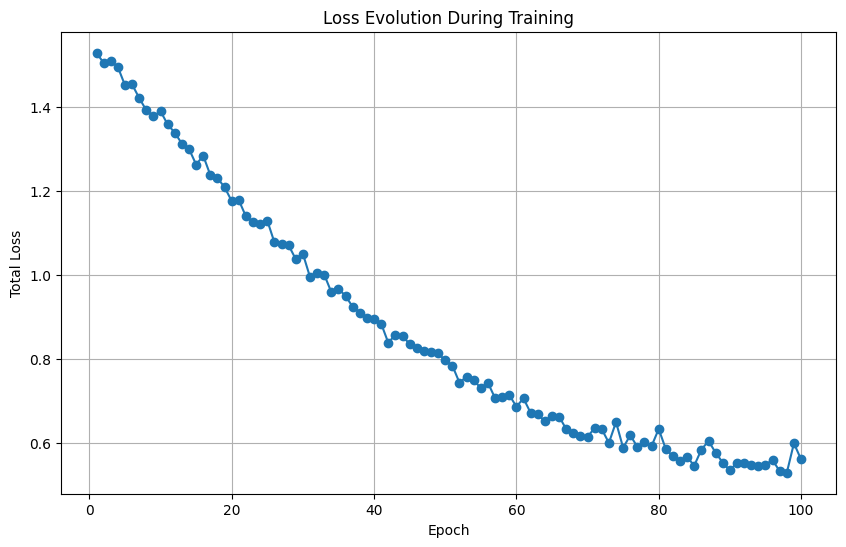

In [15]:
# Avoid parallelism error from HuggingFace during training
tokenizer.parallelism = False

# Train the model using FHE simulation
train_custom_model(hybrid_model, train_dataloader, training_args, fhe="simulate")

In [16]:
# Get the fine-tuned model
fine_tuned_model = hybrid_model.model.inference_model

# Set FHE mode to disable for text generation
hybrid_model.set_fhe_mode("disable")

In [17]:
# Inference using the fine-tuned model with LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

prompt = "What is FHE?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

What is FHE?

Fully Fully Scaled FFI™ Cryptographic Provider (FHE) is the foundation for the modern healthcare system. Flete-


In [18]:
# Original inference without LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

peft_model.disable_adapter_layers()

prompt = "What is FHE?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

peft_model.enable_adapter_layers()

What is FHE?

FHE is a word that has been popularized by the Internet meme-culture meme of the 1990s.
There are two things that


In [19]:
# Print weights and model size
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124587264
Total number of LoRA weights: 147456


In [20]:
# Save the model
path = Path("deployment/gpt2_lora_finetuned")
path.mkdir(parents=True, exist_ok=True)

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [21]:
# Print weights and size after saving
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 39569664
Total number of LoRA weights: 147456


In [22]:
# Calculate and print the percentage of weights removed
percentage_removed = (total_weights_size - total_weights_size_private) / total_weights_size * 100
print(f"Total weights removed: {percentage_removed:.2f} %")

Total weights removed: 68.24 %


In [23]:
# Note: Around 95% of the remaining weights are from the embedding layers (wpe and wte)
# as well as the final lm_head layer.